# Domain Decoder: A Tool to Identify Fluoroquinolone Drug Binding Sites


## Import Libraries

In [45]:
import pandas as pd
import numpy as np
from Bio import SeqIO
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings(action='once')

## Import Data

In [46]:
data_path = "3-gram-final.csv"
sequence_path = "DNA_Gyrase_UniProt_CLEANED.fasta"

model_df = pd.read_csv(data_path, index_col=0, delimiter=',')
print("Model Head:")
print(model_df.head(10))
print("Size of the DataFrame:", model_df.shape)
unique_values = model_df.index.nunique()
print(f"Unique Values: {unique_values}")
sequences = SeqIO.to_dict(SeqIO.parse(sequence_path, "fasta"))
print("\nExample Protein Sequence:\n")
print(str(list(sequences.values())[0].seq))

Model Head:
     -0.202641  -0.44152558  0.7237159  -0.051630057  -0.1796543  -0.17303413  \
AAA                                                                             
ALA  -0.487939    -0.286591   0.723286      0.018458   -0.026013    -0.185017   
LLL  -0.209581    -0.049195   0.687492      0.043283   -0.085327    -0.166621   
LAA  -0.449757    -0.301040   0.650756     -0.038405   -0.143120    -0.177706   
AAL  -0.322143    -0.279880   0.750441      0.031342   -0.126243    -0.134607   
ALL  -0.377936    -0.210822   0.723277      0.042915   -0.042336    -0.184456   
LLA  -0.325802    -0.160612   0.716421      0.140574   -0.105720    -0.169147   
SSS   0.175785    -0.103099   0.445012     -0.116389   -0.366477    -0.205607   
LAL  -0.347601    -0.276936   0.759509      0.073802    0.040129    -0.204613   
EAL  -0.476662    -0.229644   0.596552     -0.157708   -0.179475    -0.120480   
AAG  -0.460274    -0.385322   0.771879      0.123707   -0.182858    -0.174014   

     -0.5336818

## Standardization and Vectorization
* generate_kmers - Generate overlapping k-mers of given length from a Protein sequence
* prot_vectorization - Vectorize Protein k-mers using a model loaded from a CSV file
* standardize_vectors - Standardize the feature vectors
* vectorize_sequences - Vectorize sequences based on a model DataFrame
* check_kmers_in_model - Find k-mers in model dataframe
* get_standardize_vector_sequence - Returns Standardize vectorized sequences

In [47]:
def generate_kmers(prot_sequence, k=3):
    """Generate overlapping k-mers from a Protein sequence."""
    return [prot_sequence[i:i+k] for i in range(len(prot_sequence) - k + 1)]

def prot_vectorization(kmers, model_df, dimensions):
    """Vectorize Protein k-mers using a model loaded from a CSV file."""
    vector = np.zeros((len(kmers), dimensions))
    for i, kmer in enumerate(kmers):
        if kmer in model_df.index:
            vector[i] = model_df.loc[kmer].values
    return np.mean(vector, axis=0)

def standardize_vectors(vectors):
    """Standardize the feature vectors."""
    scaler = StandardScaler()
    standardized_vectors = scaler.fit_transform(vectors)
    return standardized_vectors

def vectorize_sequences(sequences, model_df, k):
    """Vectorize sequences based on a model DataFrame."""
    vectorized_seqs = []
    seq_ids = []
    
    for seq_id, sequence in sequences.items():
        kmers = generate_kmers(str(sequence.seq), k)
        dimensions = model_df.shape[1]
        vec = prot_vectorization(kmers, model_df, dimensions)
        vectorized_seqs.append(vec)
        seq_ids.append(seq_id)
    
    return vectorized_seqs, seq_ids

def check_kmers_in_model(kmers, model_df):
    """Check if k-mers are in the model DataFrame."""
    for kmer in kmers:
        if kmer in model_df.index:
            print(f"{kmer} found in model")
        else:
            print(f"{kmer} NOT found in model")
            
def get_standardize_vector_sequence(vectorized_seqs):
    """Standardize vectorized sequences."""
    vectorized_seqs_np = np.array(vectorized_seqs)
    if len(vectorized_seqs_np.shape) == 1:
        vectorized_seqs_np = np.stack(vectorized_seqs_np, axis=0)
    
    standardized_vectors = standardize_vectors(vectorized_seqs_np)
    return standardized_vectors

In [48]:
#Reads in clustalW MSA and finds conserved regions and generates weights for the embeddings.
from Bio import AlignIO

def get_conservation_weights(alignment_file):
    alignment = AlignIO.read(alignment_file, "clustal")
    conservation_line = alignment[-1].seq  
    
    weights = {}
    for i, symbol in enumerate(conservation_line):
        if symbol == '*':  # Fully conserved
            weights[i] = 3
        elif symbol == ':':  # Strongly conserved
            weights[i] = 2
        elif symbol == '.':  # Weaker conserved
            weights[i] = 1
    
    return weights

alignment_file = "DNA_Gyrase_MSA.txt"
weights = get_conservation_weights(alignment_file)


In [49]:
# weighted embeddings for active site or regions which are conserved and thus play vital roles in the sequence function of DNA Gyrase
def weighted_prot_vectorization(kmers, model_df, dimensions, weights):

    vector = np.zeros((len(kmers), dimensions))
    for i, kmer in enumerate(kmers):
        if kmer in model_df.index:
            # Apply conservation weight if the position is conserved; otherwise, use default weight of 1
            weight = np.mean([weights.get(pos, 1) for pos in range(i, i + len(kmer))])
            vector[i] = model_df.loc[kmer].values * weight
    return np.mean(vector, axis=0)


vectorized_seqs, seq_ids = [], []

for seq_id, sequence in sequences.items():
    kmers = generate_kmers(str(sequence.seq), k=3)
    dimensions = model_df.shape[1]
    vec = weighted_prot_vectorization(kmers, model_df, dimensions, weights)  
    vectorized_seqs.append(vec)
    seq_ids.append(seq_id)

standardized_vectors = get_standardize_vector_sequence(vectorized_seqs)



In [50]:
vectorized_seqs, seq_ids = vectorize_sequences(sequences, model_df, k=3)

if len(vectorized_seqs) == 0 or vectorized_seqs[0].size == 0:
    print("No sequences were vectorized. Check the vectorization process.")
else:
    # Standardize vectors
    standardized_vectors = get_standardize_vector_sequence(vectorized_seqs)
    # Save to CSV
    df = pd.DataFrame(standardized_vectors, index=seq_ids)
    df.to_csv('gyrase_vectorized1.csv')

In [51]:
standardized = pd.read_csv("gyrase_vectorized1.csv", index_col=0, delimiter=',')
print(standardized.head)

<bound method NDFrame.head of                                        0         1         2         3  \
tr|A0A4R5W9U2|A0A4R5W9U2_9MYCO  0.014133 -0.280080  0.812567  0.345620   
tr|A0A0H3MNY6|A0A0H3MNY6_MYCLB -0.290104 -0.135887  0.702608  0.889795   
tr|A0A197S9M5|A0A197S9M5_MYCLR -0.290104 -0.135887  0.702608  0.889795   
tr|A0A3D9EFS7|A0A3D9EFS7_PSEOL  0.911812  0.187395  0.228563 -0.696701   
tr|A0A1G7ZIB0|A0A1G7ZIB0_9PSED  0.531586  0.006928  0.642278 -0.586139   
...                                  ...       ...       ...       ...   
tr|A3E5C0|A3E5C0_LEGPN         -0.586138 -0.619491 -4.630082 -1.731233   
tr|B4XJ24|B4XJ24_LEGPN          0.537957  0.035953 -3.080467 -1.686708   
tr|B4XJ68|B4XJ68_LEGPN          3.081677  1.284948 -5.344530 -3.826748   
tr|Q3ZUS6|Q3ZUS6_SALER         -2.264916 -3.134311  7.410051  0.351611   
tr|Q3ZUS4|Q3ZUS4_SALER          0.882331 -0.490632  5.732431 -1.096408   

                                       4         5         6         7  \
tr|A0A4

                                 0         1         2         3         4    \
0                                NaN  0.000000  1.000000  2.000000  3.000000   
1     tr|A0A4R5W9U2|A0A4R5W9U2_9MYCO  0.014133 -0.280080  0.812567  0.345620   
2     tr|A0A0H3MNY6|A0A0H3MNY6_MYCLB -0.290104 -0.135887  0.702608  0.889795   
3     tr|A0A197S9M5|A0A197S9M5_MYCLR -0.290104 -0.135887  0.702608  0.889795   
4     tr|A0A3D9EFS7|A0A3D9EFS7_PSEOL  0.911812  0.187395  0.228563 -0.696701   
...                              ...       ...       ...       ...       ...   
5155          tr|A3E5C0|A3E5C0_LEGPN -0.586138 -0.619491 -4.630082 -1.731233   
5156          tr|B4XJ24|B4XJ24_LEGPN  0.537957  0.035953 -3.080467 -1.686708   
5157          tr|B4XJ68|B4XJ68_LEGPN  3.081677  1.284948 -5.344530 -3.826748   
5158          tr|Q3ZUS6|Q3ZUS6_SALER -2.264916 -3.134311  7.410051  0.351611   
5159          tr|Q3ZUS4|Q3ZUS4_SALER  0.882331 -0.490632  5.732431 -1.096408   

           5         6         7       

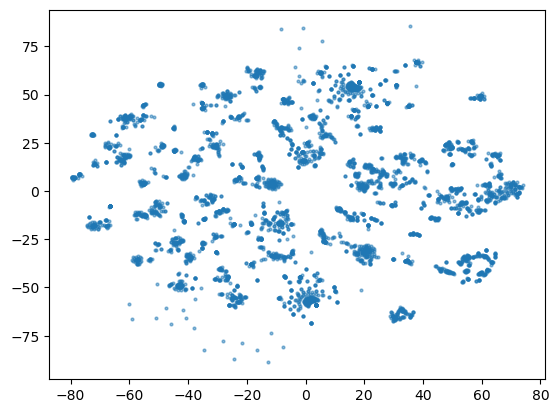

In [52]:
#!/bin/bash/env python 
import sys,json,os 
import matplotlib.pyplot as plt 
from Bio.SeqUtils.ProtParam import ProteinAnalysis 
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import pandas as pd 
kmers = [] 
# Parse prot file
with open("gyrase_vectorized1.csv","r") as f:
    for line in f:
        line = line.strip() 
        cols = line.split(',') 
        kmer = cols[0]
        if 'X' in kmer or 'Z' in kmer or 'B' in kmer or '<' in kmer:
            continue 
        kmers.append(kmer)  



X = pd.read_csv("gyrase_vectorized1.csv",header=None)
print(X)

kmer_names = X.iloc[:,0].values
X = X.iloc[:, 1:len(X.columns)-1]
X = X.values 

# t-distributed Stochastic Neighbor Embedding. (Like PCA but based on similarity not covariance)
print('-- Fitting TSNE')
pca = TSNE(n_components=2)
X_trans = pca.fit_transform(X)


print("original shape:   ", X.shape)
print("transformed shape:", X_trans.shape)

plt.scatter(X_trans[:, 1], X_trans[:, 0], alpha=0.5,s=4)
df = pd.DataFrame(X_trans,index=kmer_names)
df.to_csv("3-gram-dbtx.model")
plt.show()


# Combining Our Weighted Vector Embeddings and the Embeddings generated by ProtVec

In [54]:
from Bio import SeqIO
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained("Rostlab/prot_bert", do_lower_case=False)

# Function to tokenize sequences
def tokenize_sequences(sequence_path):
    tokenized_sequences = []
    attention_masks = []
    for record in SeqIO.parse(sequence_path, "fasta"):
        sequence = str(record.seq)
        encoded_dict = tokenizer.encode_plus(
            sequence,                      # Sequence to encode
            add_special_tokens=True,      # Add '[CLS]' and '[SEP]'
            max_length=512,               # Pad & truncate all sentences
            padding='max_length',         # Pad all to max_length
            return_attention_mask=True,   # Construct attention masks
            return_tensors='pt',          # Return PyTorch tensors
            truncation=True
        )
        tokenized_sequences.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])
    return torch.cat(tokenized_sequences, dim=0), torch.cat(attention_masks, dim=0)


input_ids, attention_masks = tokenize_sequences(sequence_path)

sequence_path = "DNA_Gyrase_UniProt_Cleaned.fasta"


In [55]:
import pandas as pd
import torch

# Load embeddings
embeddings_path = "gyrase_vectorized1.csv"
embeddings_df = pd.read_csv(embeddings_path, index_col=0)
custom_embeddings = torch.tensor(embeddings_df.values).float()


In [56]:
from torch.utils.data import Dataset, DataLoader

class ProteinDataset(Dataset):
    def __init__(self, input_ids, attention_masks, custom_embeddings):
        self.input_ids = input_ids
        self.attention_masks = attention_masks
        self.custom_embeddings = custom_embeddings

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return {
            "input_ids": self.input_ids[idx],
            "attention_mask": self.attention_masks[idx],
            "custom_embeddings": self.custom_embeddings[idx]
        }

dataset = ProteinDataset(input_ids, attention_masks, custom_embeddings)
loader = DataLoader(dataset, batch_size=4, shuffle=True)  


In [57]:
import torch
import torch.nn as nn
from transformers import BertModel

class HybridModel(nn.Module):
    def __init__(self, bert_model_name, custom_embedding_dim, hidden_dim, output_dim):
        super(HybridModel, self).__init__()
        self.bert_model = BertModel.from_pretrained(bert_model_name)
        self.concat_layer = nn.Linear(self.bert_model.config.hidden_size + custom_embedding_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.classifier = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, input_ids, attention_mask, custom_embeddings):
        # Get embeddings from ProtBERT
        with torch.no_grad():
            bert_outputs = self.bert_model(input_ids=input_ids, attention_mask=attention_mask)
            sequence_output = bert_outputs.last_hidden_state[:, 0, :]  # CLS token
        
        # Concatenate ProtBert embeddings with custom embeddings
        combined_features = torch.cat((sequence_output, custom_embeddings), dim=1)
        
        # Additional layers
        x = self.concat_layer(combined_features)
        x = self.relu(x)
        x = self.classifier(x)
        
        return x


In [58]:
file_path = 'binding_sites_info.xlsx'
df = pd.read_excel(file_path)

binding_sites_info = {}

for _, row in df.iterrows():
    identifier = row['Identifier']
    start_end_tuple = (row['Start Index'], row['End Index'])
    
    if identifier in binding_sites_info:
        binding_sites_info[identifier].append(start_end_tuple)
    else:
        binding_sites_info[identifier] = [start_end_tuple]


In [60]:
from Bio import SeqIO
from transformers import BertTokenizer

# Initialize tokenizer
tokenizer = BertTokenizer.from_pretrained("Rostlab/prot_bert", do_lower_case=False)

#label the seqs
def label_sequence(sequence, binding_sites):
    labels = [0] * len(sequence) 
    for start, end in binding_sites:  # Loop over all binding sites
        for i in range(start, end + 1):  # Mark positions within binding sites as 1
            if i < len(sequence):  
                labels[i] = 1
    return labels


def process_sequence(record, binding_sites_info):
    sequence = str(record.seq)
    labels = label_sequence(sequence, binding_sites_info[record.id])

    # Tokenize
    encoded_dict = tokenizer.encode_plus(
        sequence,
        add_special_tokens=True,
        max_length=512,
        padding='max_length',
        return_attention_mask=True,
        return_tensors='pt',
        truncation=True
    )

    # Adjust labels to account for special tokens added by tokenizer??
    padded_labels = [-100] + labels[:510] + [-100] + ([-100] * (512 - len(labels) - 2))

    return encoded_dict['input_ids'], encoded_dict['attention_mask'], padded_labels

# Loop over sequences and process each
fasta_path = "DNA_Gyrase_UniProt_Cleaned.fasta"
for record in SeqIO.parse(fasta_path, "fasta"):
    if record.id in binding_sites_info:  # Check if we have binding site info
        input_ids, attention_mask, labels = process_sequence(record, binding_sites_info)
        


In [61]:
class ProteinDataset(Dataset):
    def __init__(self, input_ids, attention_masks, custom_embeddings, labels):
        self.input_ids = input_ids
        self.attention_masks = attention_masks
        self.custom_embeddings = custom_embeddings
        self.labels = labels  # Add this line

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return {
            "input_ids": self.input_ids[idx],
            "attention_mask": self.attention_masks[idx],
            "custom_embeddings": self.custom_embeddings[idx],
            "labels": self.labels[idx]  
        }
